In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data

In [3]:
# fname_list = [
#     "ben_260523.json",
#     "jane_260523.json",
#     "ken_270523.json",
#     "ploy_270523.json",
#     "may_270523.json",
#     "paopao_270523.json",
#     "raine_270523.json",
#     "naenae_280523.json",
#     "win_280523.json",
#     "bomb_280523.json",
#     # "amanda_310523.json",
#     "boom_310523.json",
# ]

fname_list = [
    "win_110723.json",
    "ken_110723.json",
    "eye_110723.json",
    "boom_110723.json",
    "ploy_120723.json",
    "ken_120723.json",
    "ming_120723.json",
    "belle_120723.json",
    "belle_left_120723.json",
]

root_path = "dataset"
fname_list = [os.path.join(root_path, f) for f in fname_list]

In [4]:
data = []
for fname in fname_list:
    data += json.load(open(fname))

In [5]:
len(data)

1350

In [6]:
def report_class(data):
    label_count = {}
    for motion in data:
        label = motion["label"]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    print(label_count)

In [7]:
report_class(data)

{0: 270, 1: 270, 2: 270, 3: 270, 4: 270}


# Movement Visualization

In [8]:
movings = [x for x in data if x["label"] == 0]
movings_motion = [np.array(motion["motion"])[:,:3] for motion in movings]

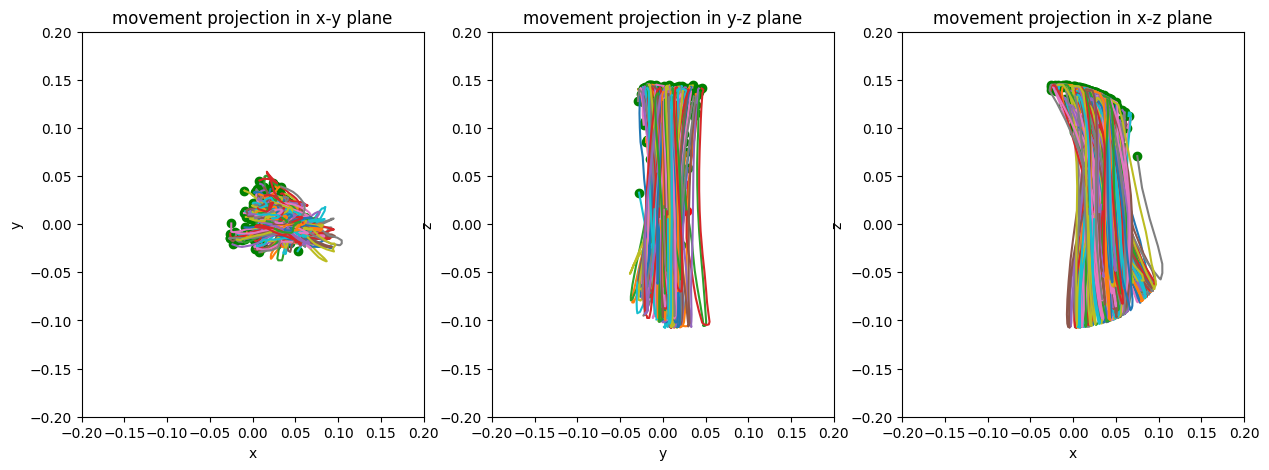

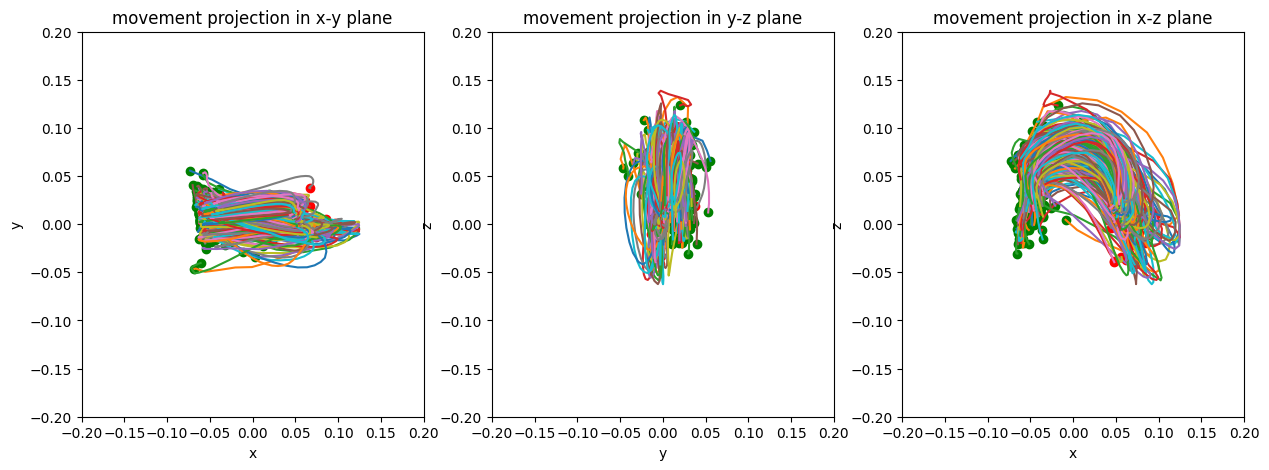

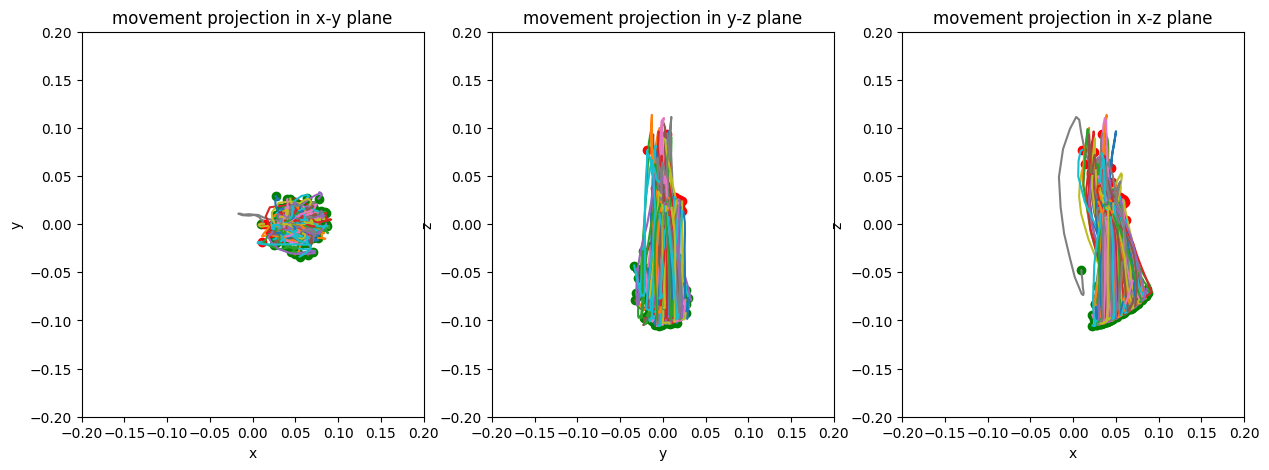

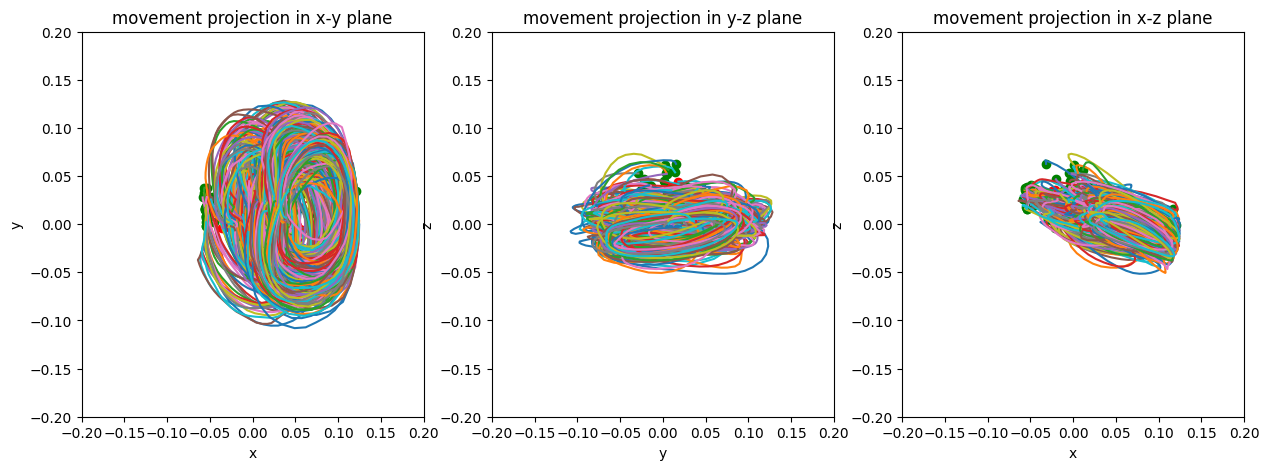

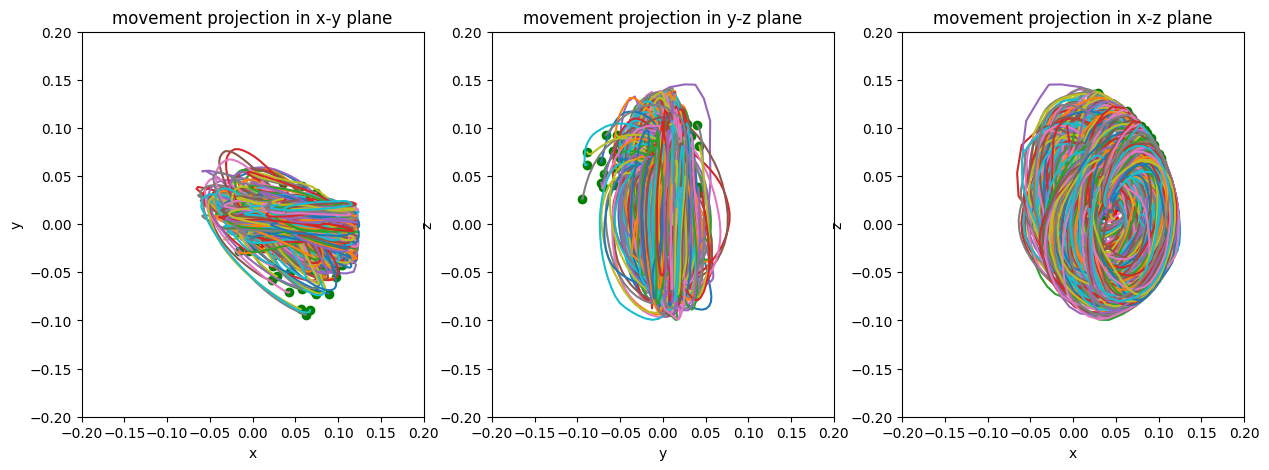

In [9]:
for i in range(5):
    movings = [x for x in data if x["label"] == i]
    movings_motion = [np.array(motion["motion"])[:,:3] for motion in movings]
    plt.figure(figsize=(15,5))
    for motion in movings_motion:
        plt.subplot(1,3,1)
        plt.plot(motion[:,0], motion[:,1], '-')
        plt.title("movement projection in x-y plane")
        plt.xlim(-0.2, 0.2)
        plt.ylim(-0.2, 0.2)
        plt.scatter(motion[0,0], motion[0,1], c='r')
        plt.scatter(motion[-1,0], motion[-1,1], c='g')
        plt.xlabel("x")
        plt.ylabel("y")
        

        plt.subplot(1,3,2)
        plt.plot(motion[:,1], motion[:,2], '-')
        plt.title("movement projection in y-z plane")
        plt.xlim(-0.2, 0.2)
        plt.ylim(-0.2, 0.2)
        plt.scatter(motion[0,1], motion[0,2], c='r')
        plt.scatter(motion[-1,1], motion[-1,2], c='g')
        plt.xlabel("y")
        plt.ylabel("z")


        plt.subplot(1,3,3)
        plt.plot(motion[:,0], motion[:,2], '-')
        plt.scatter(motion[0,0], motion[0,2], c='r')
        plt.scatter(motion[-1,0], motion[-1,2], c='g')
        plt.title("movement projection in x-z plane")
        plt.xlim(-0.2, 0.2)
        plt.ylim(-0.2, 0.2)
        plt.xlabel("x")
        plt.ylabel("z")

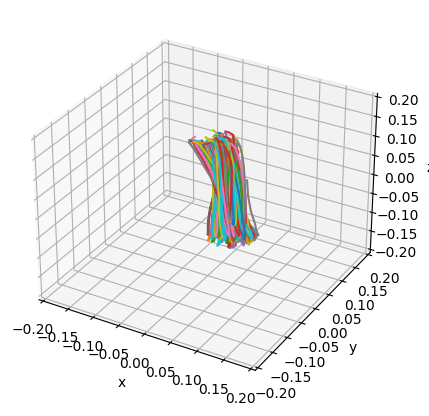

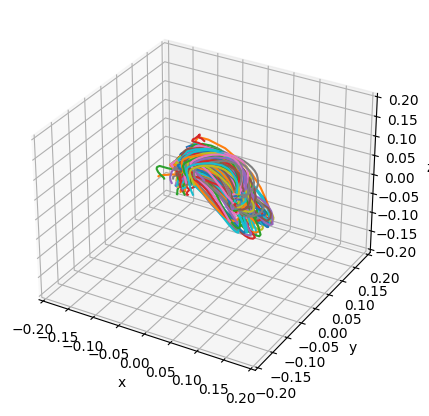

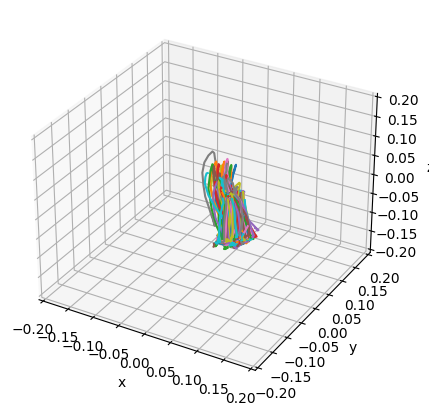

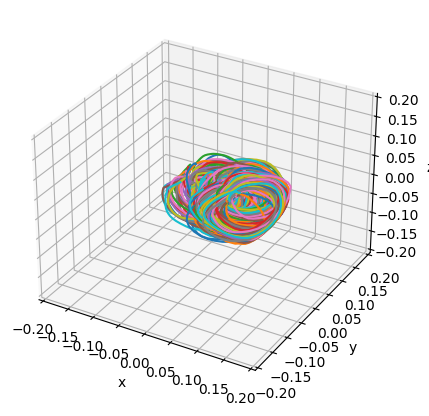

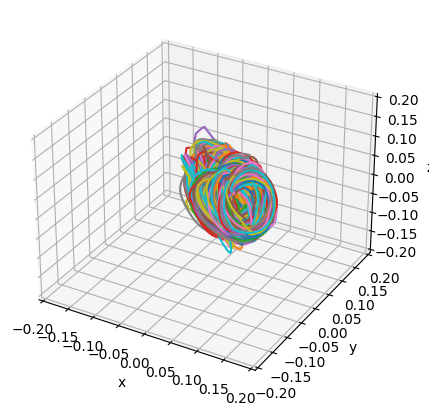

In [10]:
for i in range(5):
    movings = [x for x in data if x["label"] == i]
    movings_motion = [np.array(motion["motion"])[:,:3] for motion in movings]
    plt.figure(figsize=(5,5))
    ax = plt.axes(projection='3d')
    for motion in movings_motion:
        ax.plot3D(motion[:,0], motion[:,1], motion[:,2])
    plt.xlabel("x")
    plt.ylabel("y")
    ax.set_zlabel("z")
    plt.xlim(-0.2, 0.2)
    plt.ylim(-0.2, 0.2)
    ax.set_zlim(-0.2, 0.2)
    plt.show()

# Data Preprocessing

In [11]:
max_len = max([len(x['motion']) for x in data]) + 4 # find max length of the sequence to perform zero padding plus a buffer
print("Max Length : ", max_len)
num_classes = max(x['label'] for x in data) + 1 # find the total number of classes
print("Number of classes : ", num_classes)

Max Length :  170
Number of classes :  5


In [12]:
def data_augment(tmp_x, n=5, translation=True, scale=True, origin=(0.04, 0.00, 0.02)):
    augment_data = []
    tmp_x_aug = tmp_x.copy()
    for i in range(n):

        if scale:
            factor = np.random.normal(loc=1.0, scale=0.2, size=1)
            tmp_x_aug = factor * (tmp_x_aug - np.array(origin)) + np.array(origin)

        if translation:
            offset = np.random.normal(loc=0.0, scale=0.03, size=3)
            tmp_x_aug = tmp_x_aug + offset
            
        augment_data.append(tmp_x_aug)
    augment_data = np.stack(augment_data)
    return augment_data

In [13]:
y = []
X = []
X_augment = []
y_augment = []
for x in data:
    # One-hot encoder
    tmp_y = np.zeros((num_classes))
    tmp_y[x['label']] = 1.0
    y.append(tmp_y)
    
    tmp_x = np.array(x['motion'])[:,:3] # include only position x,y,z
    n_augment = 5
    augment_data = data_augment(tmp_x, n=n_augment)
    augment_data = np.concatenate([augment_data, np.zeros((augment_data.shape[0], max_len - augment_data.shape[1], augment_data.shape[2]))], axis=1)
    tmp_x = np.concatenate([tmp_x, np.zeros((max_len - tmp_x.shape[0], tmp_x.shape[1]))]) # zero padding
    # tmp_x_lag = np.concatenate([np.zeros((1, tmp_x.shape[1])), tmp_x[:-1, :]]) # lag 1
    # velocity = tmp_x - tmp_x_lag
    # tmp_x = np.concatenate([tmp_x, velocity], axis=1)
    y_augment.extend([tmp_y] * (n_augment))
    X.append(tmp_x)
    X_augment.extend(list(augment_data))
X = np.stack(X)
y = np.stack(y)
X_augment = np.stack(X_augment)
y_augment = np.stack(y_augment)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(X_train.shape)
print(X_test.shape)

(1080, 170, 3)
(270, 170, 3)


In [16]:
X_train = np.concatenate([X_train, X_augment])
y_train = np.concatenate([y_train, y_augment])

In [17]:
print(X_train.shape)
print(X_test.shape)

(7830, 170, 3)
(270, 170, 3)


# Model CNN

In [26]:
def make_model(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)
    fc =tf.keras.layers.Dense(100, activation="ReLU")(gap)
    dropout = tf.keras.layers.Dropout(0.5)(fc)
    output_layer =tf.keras.layers.Dense(num_classes, activation="softmax")(dropout)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
model_name = "best_cnn_model.h5"
epochs = 400
batch_size = 16

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
392/392 [==============================] - 3s 4ms/step - loss: 1.3840 - categorical_accuracy: 0.4756 - val_loss: 1.5122 - val_categorical_accuracy: 0.3346 - lr: 0.0010
Epoch 2/400
392/392 [==============================] - 1s 4ms/step - loss: 0.9957 - categorical_accuracy: 0.6625 - val_loss: 1.5246 - val_categorical_accuracy: 0.5485 - lr: 0.0010
Epoch 3/400
392/392 [==============================] - 1s 3ms/step - loss: 0.7711 - categorical_accuracy: 0.7411 - val_loss: 0.9230 - val_categorical_accuracy: 0.6635 - lr: 0.0010
Epoch 4/400
392/392 [==============================] - 1s 3ms/step - loss: 0.6526 - categorical_accuracy: 0.7874 - val_loss: 1.7258 - val_categorical_accuracy: 0.5543 - lr: 0.0010
Epoch 5/400
392/392 [==============================] - 1s 3ms/step - loss: 0.5374 - categorical_accuracy: 0.8295 - val_loss: 7.8913 - val_categorical_accuracy: 0.2101 - lr: 0.0010
Epoch 6/400
392/392 [==============================] - 1s 3ms/step - loss: 0.4685 - categorical_accu

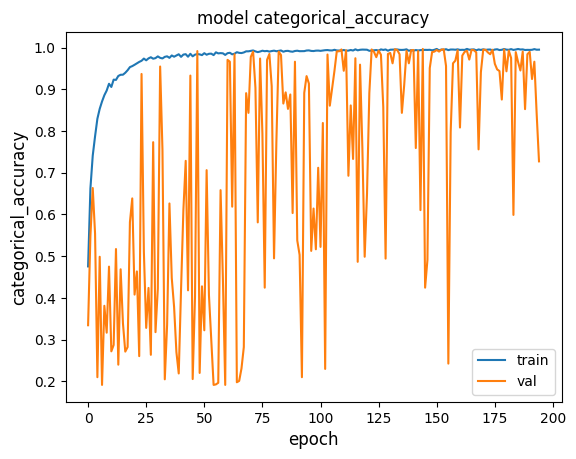

In [28]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [29]:
model_name = "best_cnn_model.h5"
model = tf.keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

9/9 [==============================] - 0s 1ms/step - loss: 0.0075 - categorical_accuracy: 0.9926
Test accuracy 0.9925925731658936
Test loss 0.007534087169915438


In [30]:
from sklearn.metrics import classification_report

threshold = 0.8
y_pred = model.predict(X_test)
cond = y_pred.max(axis=1)>threshold
print(cond.mean())
y_pred_bool = np.argmax(y_pred[cond], axis=1)
y_test_bool = np.argmax(y_test[cond], axis=1)

print(classification_report(y_test_bool, y_pred_bool))

9/9 [==============================] - 0s 2ms/step
0.9925925925925926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00        51
           4       1.00      1.00      1.00        54

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



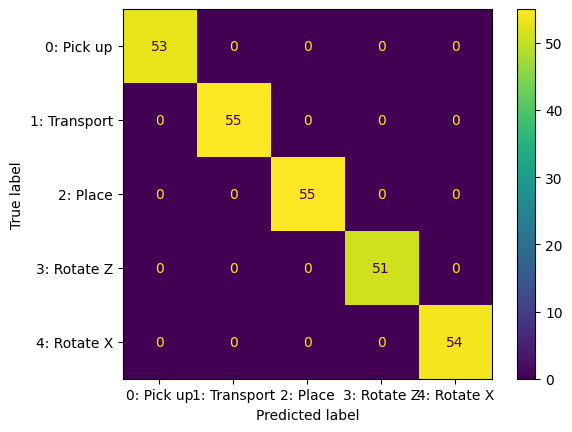

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_bool, 
                                        y_pred_bool, 
                                        display_labels=["0: Pick up","1: Transport","2: Place","3: Rotate Z","4: Rotate X"],
                                        )

# Model LSTM

In [36]:
def make_model(n_features):
    model = tf.keras.Sequential()
    # model.add(tf.keras.layers.LSTM(200, input_shape=(None, n_features)))
    model.add(tf.keras.layers.LSTM(600, input_shape=(None, n_features), return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.LSTM(600, ))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model


model = make_model(n_features=X_train.shape[2])

In [37]:
model_name = 'best_lstm_model.h5'
epochs = 300
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/300
 54/196 [=======>......................] - ETA: 6:38 - loss: 1.6120 - categorical_accuracy: 0.2043

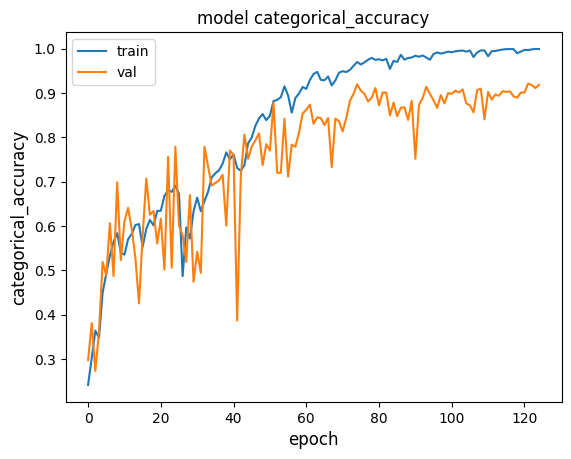

In [ ]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
model = tf.keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

4/4 [==============================] - 1s 55ms/step - loss: 0.0167 - categorical_accuracy: 1.0000
Test accuracy 1.0
Test loss 0.016717545688152313


In [ ]:
from sklearn.metrics import classification_report

threshold = 0.8
y_pred = model.predict(X_test)
cond = y_pred.max(axis=1)>threshold
print(cond.mean())
y_pred_bool = np.argmax(y_pred[cond], axis=1)
y_test_bool = np.argmax(y_test[cond], axis=1)

print(classification_report(y_test_bool, y_pred_bool))

4/4 [==============================] - 1s 48ms/step
0.975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        32
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        28

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117



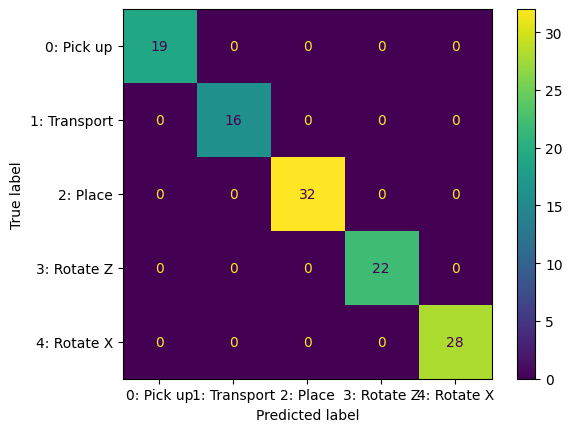

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_bool, 
                                        y_pred_bool, 
                                        display_labels=["0: Pick up","1: Transport","2: Place","3: Rotate Z","4: Rotate X"],
                                        )